In [1]:
#@title **TRANSFER LEARNING**

In [1]:
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
import tensorflow_hub as hub
import datetime
import matplotlib.pyplot as plt


In [2]:
!nvidia-smi

Mon Dec 12 14:02:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import zipfile
# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2022-12-12 14:03:21--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 172.217.194.128, 142.251.10.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  22.8MB/s    in 8.0s    

2022-12-12 14:03:29 (20.2 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
#@title unzip dataset

zip_data = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_data.extractall()
zip_data.close()

In [5]:
# check data directory, path
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"there are filenames in {len(filenames)} in directory {len(dirnames)} in the path of {dirpath}")


there are filenames in 0 in directory 2 in the path of 10_food_classes_10_percent
there are filenames in 0 in directory 10 in the path of 10_food_classes_10_percent/test
there are filenames in 250 in directory 0 in the path of 10_food_classes_10_percent/test/grilled_salmon
there are filenames in 250 in directory 0 in the path of 10_food_classes_10_percent/test/hamburger
there are filenames in 250 in directory 0 in the path of 10_food_classes_10_percent/test/chicken_wings
there are filenames in 250 in directory 0 in the path of 10_food_classes_10_percent/test/sushi
there are filenames in 250 in directory 0 in the path of 10_food_classes_10_percent/test/ramen
there are filenames in 250 in directory 0 in the path of 10_food_classes_10_percent/test/ice_cream
there are filenames in 250 in directory 0 in the path of 10_food_classes_10_percent/test/fried_rice
there are filenames in 250 in directory 0 in the path of 10_food_classes_10_percent/test/pizza
there are filenames in 250 in directory 

In [6]:
#@title TENSORBOARD API log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


def callbacks_tensorboard(dir_name,experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_logdir = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )

  print(f"Saving to log_dir: {log_dir}")
  return tensorboard_logdir

In [7]:
#@title PREPARE DATASET

IMAGE_SHAPE=(224,224)
BATCH_SIZE=32

train_dir = "/content/10_food_classes_10_percent/train/"
test_dir = "/content/10_food_classes_10_percent/test/"

In [8]:
#@title ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training Samples: ")
train_datagen_10 = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
print("\n")
print("Testing Samples: ")
test_datagen_10 = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Training Samples: 
Found 750 images belonging to 10 classes.


Testing Samples: 
Found 2500 images belonging to 10 classes.


In [9]:
#@title _EFFICIENT_B0_ AND _RESNET_V2_50 FOR IMAGE CLASSIFICATION FROM **TENSORFLOW HUB**

url_efficient_b0 = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"
url_resnetv2_50 = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

In [10]:
#create modeL FOR RESNETV2-50

def model_create(model_url, num_classes):

  feature_extraction_layer = hub.KerasLayer(url_resnetv2_50,
                         trainable=False,
                         name='feature_extraction_layer',
                         input_shape=IMAGE_SHAPE + (3,)) #

  ## add last dense layer

  model = tf.keras.Sequential([
      feature_extraction_layer,
      tf.keras.layers.Dense(num_classes, activation='softmax', name="output_dense")
  ])

  return model

In [11]:
resnet_model = model_create(url_resnetv2_50, num_classes=train_datagen_10.num_classes)

In [14]:
resnet_model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer = tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [26]:
#@title with callbacks
resnet_history = resnet_model.fit(train_datagen_10, epochs=10, steps_per_epoch=len(train_datagen_10), validation_data=test_datagen_10, 
                                  validation_split=len(test_datagen_10),
                                  callbacks = [callbacks_tensorboard(dir_name="tensorflow_resnet",
                                                                     experiment_name="ResnetV2--50")])

Saving to log_dir: tensorflow_resnet/ResnetV2--50/20221212-095529
Epoch 1/10
24/24 [==============================] - 29s 748ms/step - loss: 1.8560 - accuracy: 0.3693 - val_loss: 1.1533 - val_accuracy: 0.6440
Epoch 2/10
24/24 [==============================] - 16s 670ms/step - loss: 0.8690 - accuracy: 0.7520 - val_loss: 0.8116 - val_accuracy: 0.7472
Epoch 3/10
24/24 [==============================] - 16s 673ms/step - loss: 0.5869 - accuracy: 0.8440 - val_loss: 0.7237 - val_accuracy: 0.7692
Epoch 4/10
24/24 [==============================] - 16s 706ms/step - loss: 0.4562 - accuracy: 0.8880 - val_loss: 0.6864 - val_accuracy: 0.7808
Epoch 5/10
24/24 [==============================] - 24s 1s/step - loss: 0.3784 - accuracy: 0.9173 - val_loss: 0.6587 - val_accuracy: 0.7856
Epoch 6/10
24/24 [==============================] - 16s 675ms/step - loss: 0.3069 - accuracy: 0.9373 - val_loss: 0.6534 - val_accuracy: 0.7888
Epoch 7/10
24/24 [==============================] - 16s 668ms/step - loss: 0.25

In [15]:
#@title Without Callbacks
resnet_history = resnet_model.fit(train_datagen_10, epochs=10, steps_per_epoch=len(train_datagen_10), validation_data=test_datagen_10, 
                                  validation_split=len(test_datagen_10))

Epoch 1/10
24/24 [==============================] - 28s 745ms/step - loss: 1.9004 - accuracy: 0.3613 - val_loss: 1.1962 - val_accuracy: 0.6316
Epoch 2/10
24/24 [==============================] - 16s 667ms/step - loss: 0.8956 - accuracy: 0.7347 - val_loss: 0.8681 - val_accuracy: 0.7252
Epoch 3/10
24/24 [==============================] - 15s 662ms/step - loss: 0.6181 - accuracy: 0.8173 - val_loss: 0.7944 - val_accuracy: 0.7296
Epoch 4/10
24/24 [==============================] - 16s 693ms/step - loss: 0.4778 - accuracy: 0.8653 - val_loss: 0.7138 - val_accuracy: 0.7616
Epoch 5/10
24/24 [==============================] - 16s 686ms/step - loss: 0.3799 - accuracy: 0.9080 - val_loss: 0.6928 - val_accuracy: 0.7692
Epoch 6/10
24/24 [==============================] - 15s 660ms/step - loss: 0.3159 - accuracy: 0.9413 - val_loss: 0.6684 - val_accuracy: 0.7740
Epoch 7/10
24/24 [==============================] - 15s 662ms/step - loss: 0.2643 - accuracy: 0.9493 - val_loss: 0.6521 - val_accuracy: 0.7736

ValueError: ignored

In [43]:
!tensorboard dev upload --logdir ./tensorflow_resnet/



***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_resnet/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=TS1ZR5Ulv5aFUHK1kLAamUHllMFt1x&prompt=consent&access_type=

In [44]:
!tensorboard dev list

https://tensorboard.dev/experiment/frofw8D9QcyebGkRgZAX8w/
	Name                 [No Name]
	Description          [No Description]
	Id                   frofw8D9QcyebGkRgZAX8w
	Created              2022-12-12 10:11:16 (4 minutes ago)
	Updated              2022-12-12 10:11:17 (4 minutes ago)
	Runs                 2
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  1719970
Total: 1 experiment(s)


In [ ]:
#@title RESULT OF RESNETV2-50  https://tensorboard.dev/experiment/frofw8D9QcyebGkRgZAX8w/#scalars&_smoothingWeight=0.609

In [17]:
#@title LETS START WITH EFFIFICIENTB0

#creat model for efficinet b0

def create_model(model_url, num_classes):

  feature_extraction_efficentb0 = hub.KerasLayer(model_url, trainable=False,
                                                 name="efficient_feature_extraction",
                                                 input_shape=IMAGE_SHAPE+(3,))
  model = tf.keras.Sequential([
      
      feature_extraction_efficentb0,
      tf.keras.layers.Dense(num_classes, activation='softmax', name="efficinet_layer_dense")
  ])
  return model


In [54]:
model_efficient = create_model(url_efficient_b0, num_classes=train_datagen_10.num_classes)

In [55]:
model_efficient.compile(  
                      
    loss=tf.keras.losses.categorical_crossentropy,

    optimizer=tf.keras.optimizers.Adam(),

    metrics = ['accuracy']
)


In [56]:
model_efficient.fit(train_datagen_10, epochs=10, steps_per_epoch=len(train_datagen_10), validation_data=test_datagen_10, validation_steps=len(test_datagen_10),
                    callbacks=[callbacks_tensorboard(dir_name="tensorflow_ufficinet",
                                                     experiment_name="EFFICINET IMAGE")])

Saving to log_dir: tensorflow_ufficinet/EFFICINET IMAGE/20221212-102838
Epoch 1/10
24/24 [==============================] - 26s 716ms/step - loss: 1.8113 - accuracy: 0.4333 - val_loss: 1.2796 - val_accuracy: 0.7416
Epoch 2/10
24/24 [==============================] - 15s 643ms/step - loss: 1.0389 - accuracy: 0.7733 - val_loss: 0.8529 - val_accuracy: 0.8220
Epoch 3/10
24/24 [==============================] - 15s 647ms/step - loss: 0.7443 - accuracy: 0.8333 - val_loss: 0.6885 - val_accuracy: 0.8464
Epoch 4/10
24/24 [==============================] - 15s 645ms/step - loss: 0.5946 - accuracy: 0.8693 - val_loss: 0.6049 - val_accuracy: 0.8560
Epoch 5/10
24/24 [==============================] - 15s 641ms/step - loss: 0.5043 - accuracy: 0.8893 - val_loss: 0.5521 - val_accuracy: 0.8600
Epoch 6/10
24/24 [==============================] - 15s 646ms/step - loss: 0.4388 - accuracy: 0.9027 - val_loss: 0.5187 - val_accuracy: 0.8656
Epoch 7/10
24/24 [==============================] - 24s 1s/step - loss

In [58]:
!tensorboard dev upload --logdir ./tensorflow_ufficinet/

Upload started and will continue reading any new data as it's added to the logdir.

To stop uploading, press Ctrl-C.

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/Xc1ZL1xwSnmQG9a6zfySaQ/

[2022-12-12T10:34:00] Started scanning logdir.
[2022-12-12T10:34:01] Total uploaded: 60 scalars, 0 tensors, 1 binary objects (3.9 MB)


Interrupted. View your TensorBoard at https://tensorboard.dev/experiment/Xc1ZL1xwSnmQG9a6zfySaQ/
Traceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
  File "/usr/local/lib/python3.8/dist-packages/tensorboard/main.py", line 46, in run_main
    app.run(tensorboard.main, flags_parser=tensorboard.configure)
  File "/usr/local/lib/python3.8/dist-packages/absl/app.py", line 308, in run
    _run_main(main, args)
  File "/usr/local/lib/python3.8/dist-packages/absl/app.py", line 254, in _run_main
    sys.exit(main(argv))
  File "/usr/local/lib/python3.8/dist-packages/tensor

In [ ]:
#@title **EFFICINET RESULTS**: https://tensorboard.dev/experiment/Xc1ZL1xwSnmQG9a6zfySaQ/   **EFFICINET OVERCOMES RESNETV2-50 ON LOSS CURVE AND ACCURACY FOR VALIDATION STEPS**

In [29]:
#@title MATPLOTLIB METRICS

def plot_curves(history):

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(10)
  #cureve
  #loss

  plt.plot(loss, epochs, label="Training Loss")
  plt.plot(val_loss, epochs, label = "Validation Loss")
  plt.title("Loss Model")
 # plt.axis(False)
  plt.legend()
  plt.figure()


  plt.plot( accuracy, epochs, label="Training Accuracy")
  plt.plot( val_accuracy , epochs, label = "Validation Accuracy")
  plt.title("Model Accuracy")
  plt.legend()


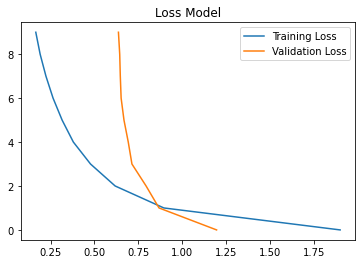

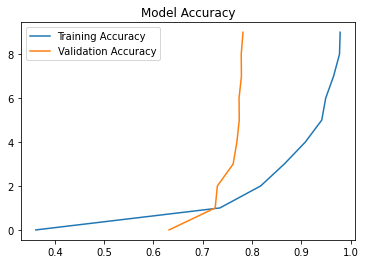

In [30]:
plot_curves(resnet_history)